In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
# pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field
from skimage.transform import resize

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate

In [2]:
from rtmag.paper.load import load_input_label, MyModel

In [3]:
meta_path = "/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt"

In [4]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/12673")
len(input_files), len(label_files)

(389, 389)

In [5]:
idx = 106
input_files[idx], label_files[idx]

(PosixPath('/mnt/f/isee_dataset/12673/input/input_12673_20170905_000000.npz'),
 PosixPath('/mnt/f/isee_dataset/12673/label/label_12673_20170905_000000.npz'))

In [6]:
mm = MyModel(meta_path)

Model loaded from epoch 75


In [7]:
B = mm.get_label(label_files[idx])
Bp = mm.get_pot(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [8]:
b_bottom = B[:, :, 0, :] 
b_bottom = np.pad(b_bottom, ((0, 0), (128, 128), (0, 0)), mode='constant')
b_bottom.shape

(512, 512, 3)

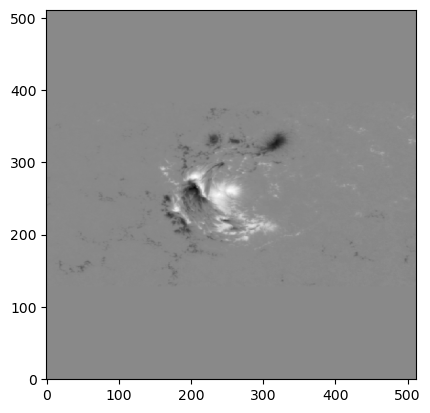

In [9]:
plt.imshow(b_bottom[:, :, 2].T, origin='lower', cmap='gray')

In [10]:
meta_path = Path("/home/mgjeon/space/workspace/_bases/base_etc/uno_pi_cc_hnorm_unit_aug_ccc_square_energy_lowlou2")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [11]:
b_norm = 2500
b_norm

2500

In [12]:
model_input = b_bottom
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

torch.Size([1, 1, 512, 512, 3])

In [13]:
model_output = model(model_input)

In [14]:
model_output.shape

torch.Size([1, 64, 512, 512, 3])

In [15]:
b = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1)
b = b * divi
b = b[:, 128:-128, :, :]
b.shape

(512, 256, 64, 3)

In [16]:
lab = B[:, :, :64, :]
lab.shape

(512, 256, 64, 3)

In [17]:
evaluate(b, lab)

C_vec     : 0.6493
C_cs      : 0.1425
E_n'      : 0.1119
E_m'      : -0.0616
eps       : 0.2468
CW_sin    : 0.8778
L_f       : 439.7125
L_d       : 493.9227
l2_err    : 0.7767


{'C_vec': 0.6492638295609933,
 'C_cs': 0.14250969886648354,
 "E_n'": 0.11186521974424846,
 "E_m'": -0.0615644313841206,
 'eps': 0.24675950499230404,
 'CW_sin': 0.8777921986800599,
 'L_f': 439.71246900209474,
 'L_d': 493.92267779670027,
 'l2_err': 0.7766659803793395}

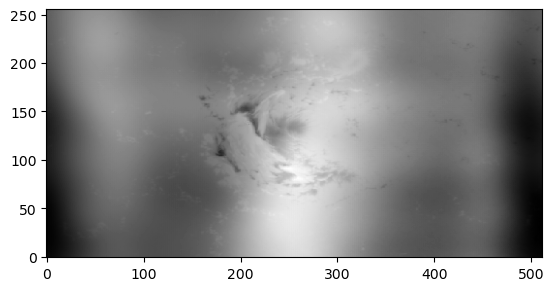

In [18]:
plt.imshow(b[:, :, 50, 2].T, origin='lower', cmap='gray')

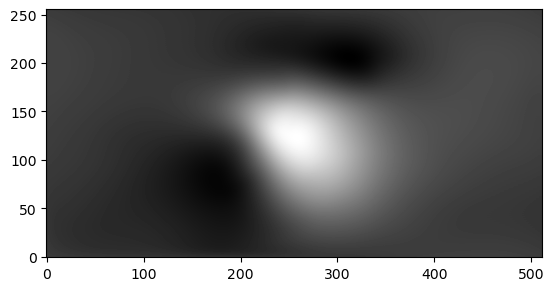

In [19]:
plt.imshow(lab[:, :, 50, 2].T, origin='lower', cmap='gray')

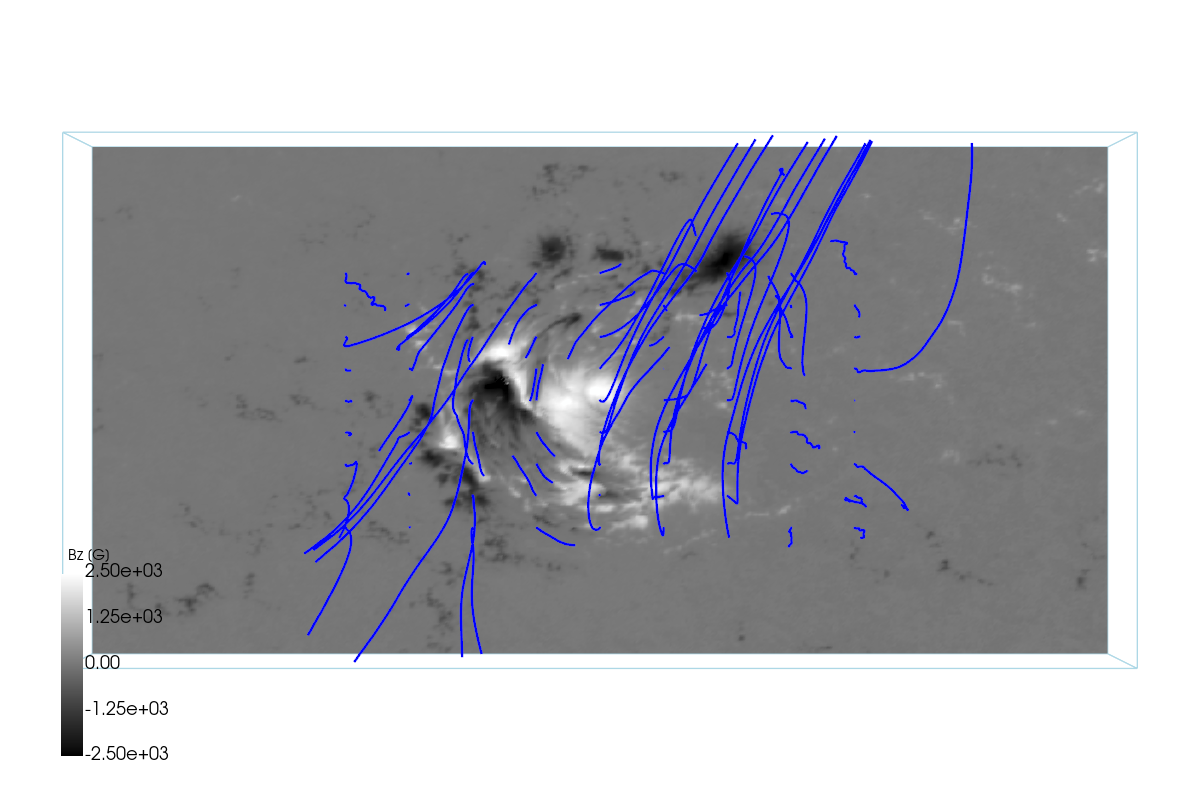

In [20]:
vmin = -2500
vmax = 2500
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

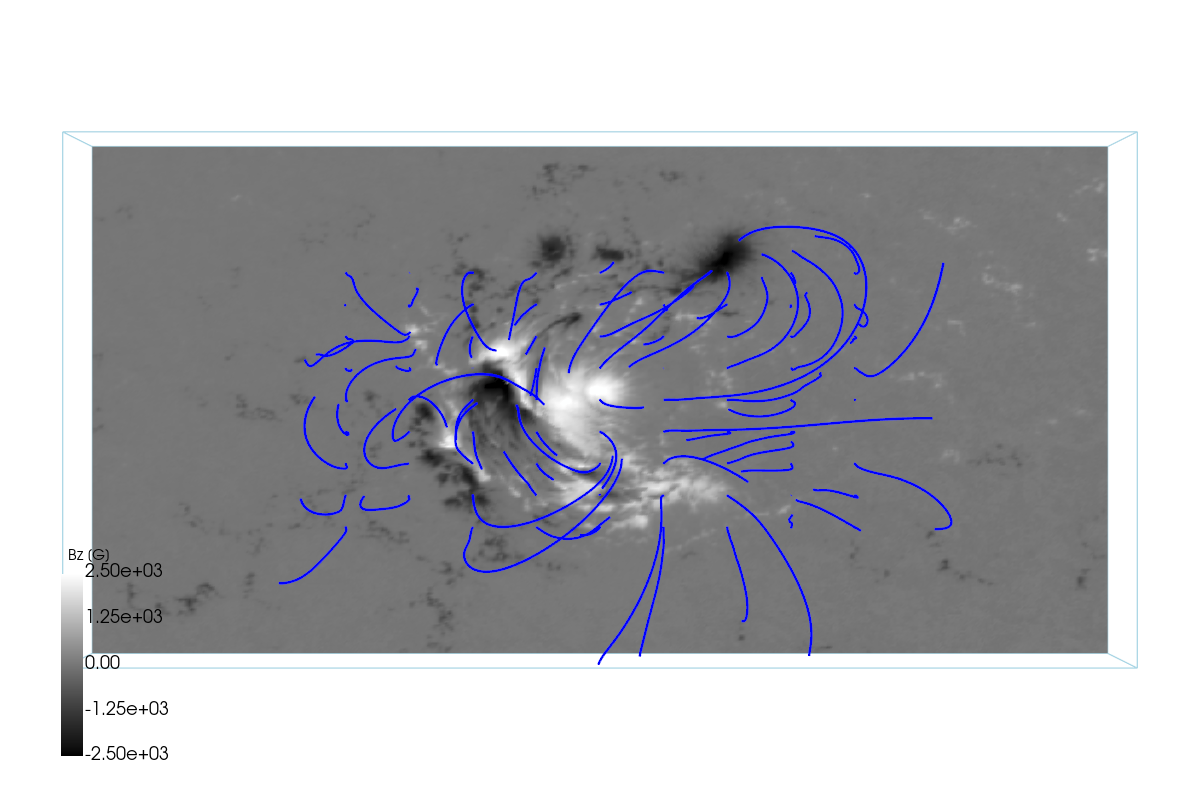

In [21]:
vmin = -2500
vmax = 2500
i_siz=lab.shape[0] / 2
j_siz=lab.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = lab[..., 0]
by = lab[..., 1]
bz = lab[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()